# Alert Linear Classifier

In [1]:
import torch
import os
import sys
import json
import copy
import mmcv
import cv2
import random
import subprocess
import numpy as np
import pickle as pkl
from collections import defaultdict
from fvcore.common.file_io import PathManager
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve
from skimage.measure import block_reduce

from slowfast.datasets.ava_helper import parse_bboxes_file
from slowfast.datasets.cv2_transform import revert_scaled_boxes
from slowfast.utils.ava_eval_helper import (
    make_image_key,
    read_labelmap,
    read_csv,
    
)
from slowfast.visualization.video_visualizer import VideoVisualizer



root_dir = '/n/fs/vai-bwc-scr/'
vid_dir = os.path.join(root_dir, 'TW_videos/')
out_dir = os.path.join(root_dir, 'action_detection/outputs/')

# Police Body-worn Camera Action annotations 
POBCA_PATH = os.path.join(root_dir, 'action_detection/annotations/audit.json')
# Slowfast predictions path
PREDS_PATH = os.path.join(root_dir, 'action_detection/annotations/bwc_frames_shifted_0.csv')
AVA_CLS = os.path.join(root_dir, 'action_detection/slowfast/demo/AVA/ava_classnames.json')
LABELMAP = '/n/fs/vai-bwc-scr/action_detection/annotations/bwc_ava_action_labelmap.pbtxt'
ALERT_FEATS_PATH = '/n/fs/vai-bwc-scr/action_detection/annotations/alert_features.pkl'

C3D_extractor = os.path.join(root_dir, 'action_detection/scripts/extract_C3D_feature.py')



In [12]:
vid_names = ['Body-Cam Video #1.mp4', 'Body-Cam Video #3.mp4','AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP 415.mp4']
for vid in vid_names[2:]:
    ext_dir = os.path.join(out_dir, 'C3D',vid[:-4].replace(' ', '_'))
    if not os.path.exists(ext_dir):
        os.mkdir(ext_dir)
    subprocess.check_call(['python', C3D_extractor, os.path.join(vid_dir, vid), ext_dir])


CalledProcessError: Command '['python', '/n/fs/vai-bwc-scr/action_detection/scripts/extract_C3D_feature.py', '/n/fs/vai-bwc-scr/TW_videos/AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP 415.mp4', '/n/fs/vai-bwc-scr/action_detection/outputs/C3D/AXON_Body_2_Video_2019-07-08_065_848x480_redactedAP_415']' returned non-zero exit status 1.

## Load data

In [3]:
def load_gt_annos(gt_path, d_labels, d_scores, categories):
    
    with open(gt_path) as f:                                                                                                                                                       
        bwc_data = json.load(f)
    
    gt_boxes = defaultdict(list)
    gt_labels = defaultdict(list)
    gt_scores = defaultdict(list)
    for vid in bwc_data:
        title = vid['data']['image_url'][0].split('/')[0]
        num_frames = len(vid['data']['image_url'])
        for bbox in vid['result']['data']:

            frame_sec = int(bbox['frame'])

            image_key = make_image_key(title, frame_sec)
            
            # ignore first person labels - irrelevant for AVA
            if 'First Person POV' in bbox['category']:
                continue
            
            # prediction failure
            if image_key not in d_labels:
                d_labels[image_key] = [int(item['id']) for item in categories]
                d_scores[image_key] = [0.0]*len(categories)

            box_list = bbox['coordinate']
            box = [box_list[0]['y'], box_list[0]['x'], box_list[2]['y'], box_list[2]['x']]

            # search for matching BWC labels in AVA category labels
            for label in bbox['labelAttrs']:
                if len(label['value']) != 0:
                    for label_val in label['value']:
                        for item in categories:
                            if item['name'].split(' ')[0] in label_val.lower() or item['name'].split('/')[0] in label_val.lower():
                                gt_boxes[image_key].append(box)
                                gt_labels[image_key].append(int(item['id']))
                                gt_scores[image_key].append(1.0)

    return gt_boxes, gt_labels, gt_scores

def load_alert_features(feat_path):
    feats = pkl.load(open(feat_path, 'rb'))
    return feats

def create_alert_labels(gt_labels, d_labels, d_scores, alert_feats, num_classes):
    alert_dict = {}
    # frame in detections but not in gt
    #for image_key in d_labels:
    #    alert_label = 0
    #    if image_key not in gt_labels and alert_feats[image_key].shape[0] == 691200:
    #        alert_dict[image_key] = [alert_feats[image_key], alert_label]
            
    # iterate through all detected frames
    for image_key in d_labels:
        if alert_feats[image_key].shape[0] != 691200:
            continue
            
        alert_label = 0
        
        # false positive
        if image_key not in gt_labels:
            alert_dict[image_key] = [alert_feats[image_key], alert_label]
            continue
            
        # iterate through all detected boxes  
        for box_idx in range(int(len(d_labels[image_key])/num_classes)):
            curr_labels = d_labels[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_labels[image_key]))]
            curr_scores = d_scores[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_scores[image_key]))]
            # iterate through all possible gt matches 
            for cls_idx in gt_labels[image_key]: 
                d_idx = curr_labels.index(int(cls_idx))
                score = curr_scores[d_idx]
                # score above threshold -> matches a gt action class
                if (int(cls_idx) == 14 and score > 0.57) or (int(cls_idx) == 11 and score > 0.04) or \
                    ((int(cls_idx) == 3) or (int(cls_idx) == 12) and score > 0.01) or (int(cls_idx) == 30 and score > 0.02):
                    alert_label = 1
                    break 
        alert_dict[image_key] = [alert_feats[image_key], alert_label]

    return alert_dict
            
def k_fold_split(info, k):
    names = np.array(list(info.keys()))
    interval = names.shape[0]//k
    random.shuffle(names)
    fts_and_labels = []
    test_keys = []
    for split in range(k):
        mask = np.zeros(names.shape)
        mask[split*interval:min((split+1)*interval, len(names))] = 1
        train = names[mask == 0]
        test = names[mask == 1]
        fold_train_fts = []
        fold_train_labels = []
        fold_test_fts = []
        fold_test_labels = [] 
        for train_name in train:
            fold_train_fts.append(info[train_name][0])
            fold_train_labels.append(info[train_name][1])
        for test_name in test:
            fold_test_fts.append(info[test_name][0])
            fold_test_labels.append(info[test_name][1]) 
        fts_and_labels.append([fold_train_fts, fold_train_labels, fold_test_fts, fold_test_labels])
        test_keys.append(test)
    return fts_and_labels, test_keys
    
def video_split(info):
    names = np.array(list(info.keys()))
    fts_and_labels = []
    train_fts = []
    train_labels = []
    test_fts = []
    test_labels = []
    test_keys = []
    for name in names:
        if 'AXON' in name or 'Video_#3' in name:
            train_fts.append(info[name][0])
            train_labels.append(info[name][1])
        else:
            test_fts.append(info[name][0])
            test_labels.append(info[name][1]) 
            test_keys.append(name)
    fts_and_labels.append([train_fts, train_labels, test_fts, test_labels])
    test_keys.append(test)
    return fts_and_labels, test_keys
    

## Train and Test

In [10]:
def train(alert_data):
    #fts_and_labels, test_keys = k_fold_split(alert_data, 5)
    fts_and_labels, test_keys = video_split(alert_data)
    models = []
    test_data = []
    for fold_train_fts, fold_train_labels, fold_test_fts, fold_test_labels in fts_and_labels:
        print(fold_train_labels)
        print(fold_test_labels)
        models.append(LinearSVC().fit(fold_train_fts, fold_train_labels))
        test_data.append([fold_test_fts, fold_test_labels])
    return models, test_data, test_keys

def test(models, test_data, test_keys):
    labels_and_scores = []
    alert_test_labels = {}
    # test models
    for i, fold in enumerate(test_data):
        test_fts = fold[0]
        test_labels = fold[1]
        score = models[i].predict(test_fts)
        labels_and_scores.append([test_labels, score])
        alert_test_labels.update(dict(zip(test_keys[i], score)))
       
    return np.array(labels_and_scores), alert_test_labels

## Evaluation

In [11]:
def plot_precision_recall(labels_and_scores):   
    # precision recall curve
    precision = dict()
    recall = dict()
    for i, fold in enumerate(labels_and_scores):
        AP = average_precision_score(fold[0], fold[1])
        precision, recall, _ = precision_recall_curve(fold[0], fold[1])
        plt.plot(recall, precision, lw=2, label='fold  '+str(i)+': {0:0.2f}'.format(AP))
    
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")

    plt.show()
    
def get_auroc(labels_and_scores):
    cross = []
    for i, fold in enumerate(labels_and_scores):
        cross.append(roc_auc_score(fold[0], fold[1]))
    return np.average(cross)

def get_f1_score(gt_labels, d_labels, d_scores, num_classes, alert_labels=None):
    pred = []
    gt = []
    overlap_classes = [3,11,12,14,30]
    keys = d_labels
    if alert_labels is not None:
        keys = alert_labels
            
    # iterate through all frames
    for image_key in keys:
        if alert_labels is not None and alert_labels[image_key] == 0:
            continue
            
        # iterate through all boxes
        for box_idx in range(int(len(d_labels[image_key])/num_classes)):
            curr_labels = d_labels[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_labels[image_key]))]
            curr_scores = d_scores[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_scores[image_key]))]                
            # iterate through all possible gt matches
            gt_label = 0
            pred_label = 0
            for idx in overlap_classes:
                # gt action class present in bbox
                if idx in gt_labels[image_key]:
                    gt_label = 1         
                d_idx = curr_labels.index(int(idx))
                score = curr_scores[d_idx]
                # score above threshold -> matches a gt action class
                if (idx == 14 and score > 0.57) or (idx == 11 and score > 0.04) or \
                    ((idx == 3) or (idx == 12) and score > 0.01) or (idx == 30 and score > 0.02):
                    pred_label = 1
                
                pred.append(pred_label)
                gt.append(gt_label)               
                
    return f1_score(gt, pred)

## Get boxes, labels, scores

In [12]:
# get detections
categories, class_whitelist = read_labelmap(LABELMAP)
num_classes = len(class_whitelist)
#print(class_whitelist)
detections = read_csv(PREDS_PATH, class_whitelist, load_score=True)
d_boxes, d_labels, d_scores = detections
# get gt labels
gt_boxes, gt_labels, gt_scores = load_gt_annos(POBCA_PATH, d_labels, d_scores, categories)

## F1 score all actions

In [13]:
score = get_f1_score(gt_labels, d_labels, d_scores, num_classes)
print(score)

0.6621180658558291


## Alert model

In [14]:
# get alert features
feats = load_alert_features(ALERT_FEATS_PATH)
# get alert labels
alert_dict = create_alert_labels(gt_labels, d_labels, d_scores, feats, num_classes)
#print(alert_dict)
print(len(alert_dict.keys()))
print(np.array(list(alert_dict.values()))[:,1])
print(sum(np.array(list(alert_dict.values()))[:,1]))
# train and test svm
models, test_data, test_keys = train(alert_dict)

321
[0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
228
[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

[[[1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1]]]
auroc: 0.41353383458646614


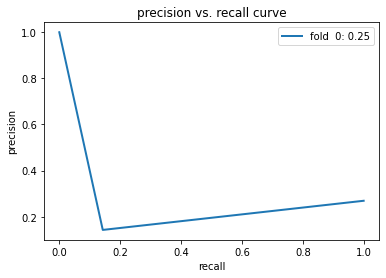

In [15]:
#for model in models:
 #   print(model.coef_)
#print(sum(np.array(test_data)[:,1][2]))
labs_scores, alert_test_labels = test(models, test_data, test_keys)
print(labs_scores)
#print(len(alert_test_labels.keys()))
#print(sum(np.array(list(alert_test_labels.values()))))
# eval
print('auroc: ' + str(get_auroc(labs_scores)))
plot_precision_recall(labs_scores)

In [85]:
#print(alert_test_labels)
score = get_f1_score(gt_labels, d_labels, d_scores, num_classes, alert_test_labels)
print(score)

0.0


/n/fs/vai-bwc-scr/miniconda/envs/pytorch-openpose/lib/python3.7/site-packages/scikit_learn-0.23.2-py3.7-linux-x86_64.egg/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


## Thresholding Action Classes

In [14]:
def get_classes(path):
        try:
            with PathManager.open(path, "r") as f:
                class2idx = json.load(f)
                return class2idx
        except Exception as err:
            print("Fail to load file from {} with error {}".format(path, err))
            return

def create_alert_labels_one_class(gt_labels, d_labels, d_scores, num_classes, idx, thres, alert_labels=None):
    pred = []
    gt = []
    keys = gt_labels
    if alert_labels is not None:
        keys = alert_labels
    # iterate through all frames
    for image_key in keys:
        if alert_labels is not None and alert_labels[image_key] == 0:
            continue
        # iterate through all boxes
        for box_idx in range(int(len(d_labels[image_key])/num_classes)):
            gt_label = 0
            pred_label = 0
            curr_labels = d_labels[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_labels[image_key]))]
            curr_scores = d_scores[image_key][box_idx*num_classes:min((box_idx+1)*num_classes, len(d_scores[image_key]))]
            # gt action class present in bbox
            if idx in gt_labels[image_key]:
                gt_label = 1

            # get detected score of action class
            d_idx = curr_labels.index(int(idx))
            score = curr_scores[d_idx]
            # score above threshold -> prediction
            if score > thres:
                pred_label = 1

            pred.append(pred_label)
            gt.append(gt_label)
                
    return pred, gt

14


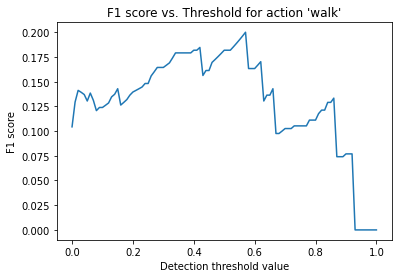

Best Threshold: 0.5700000000000001


In [15]:
class2idx = get_classes(AVA_CLS)
search_action = 'walk'
idx = [val for key, val in class2idx.items() if search_action in key][0]+1
print(idx)
# get labels
thres_range = np.linspace(0,1,101)
f1_scores = []
#pred, gt = create_alert_labels_one_class(gt_labels, d_labs, d_scores, num_classes, idx, 0.5)

for thres in thres_range:
    pred, gt = create_alert_labels_one_class(gt_labels, d_labels, d_scores, num_classes, idx, thres)#, alert_test_labels)
    f1_scores.append(f1_score(gt, pred))

plt.plot(thres_range, f1_scores)
    
plt.xlabel("Detection threshold value")
plt.ylabel("F1 score")
#plt.legend(loc="best")
plt.title("F1 score vs. Threshold for action \'"+search_action+"\'")

plt.show()

best_thres = thres_range[np.argmax(f1_scores)]
print('Best Threshold: ' + str(best_thres))



In [28]:
def load_boxes_labels(video_name, preds_boxes_path, total_frames=0, action_span=0):
    """
    Loading boxes and labels from AVA bounding boxes csv files.
    Args:
        video_name (str): name of the given video.
        preds_boxes_path  (str): path to predicted boxes file (csv)
    Returns:
        preds_boxes (dict): a dict which maps from `frame_idx` to a list of `boxes`
            and `labels`. Each `box` is a list of 4 box coordinates. `labels[i]` is
            a list of labels for `boxes[i]`. Note that label is -1 for predicted boxes.
    """
    def process_bboxes_dict(dictionary, total_frames, action_span):
        """ 
        merge all [`box_coordinate`, `box_labels`] pairs into
        [`all_boxes_coordinates`, `all_boxes_labels`] for each `keyframe_idx`.
        Args:
            dictionary (dict): a dictionary which maps `frame_idx` to a list of `box`.
                Each `box` is a [`box_coord`, `box_labels`] where `box_coord` is the
                coordinates of box and 'box_labels` are the corresponding
                labels for the box.
        Returns:
            new_dict (dict): a dict which maps from `frame_idx` to a list of `boxes`
                and `labels`. Each `box` in `boxes` is a list of 4 box coordinates. `labels[i]`
                is a list of labels for `boxes[i]`. Note that label is -1 for predicted boxes.
        """
        new_dict = {}
        for keyframe_idx, boxes_and_labels in dictionary.items():
            # Ignore keyframes with no boxes
            if len(boxes_and_labels) == 0:
                continue
            boxes, labels = list(zip(*boxes_and_labels))
            boxes = np.array(boxes)
            new_dict[keyframe_idx] = [boxes.tolist(), list(labels)]
            for i in range(action_span):
                before = max(0, keyframe_idx-i-1)
                after = min(total_frames, keyframe_idx+i+1)
                if before not in new_dict:    
                    new_dict[before] = [boxes.tolist(), list(labels)]
                if after not in new_dict:
                    new_dict[after] = [boxes.tolist(), list(labels)]
        return new_dict

    preds_boxes, _, _ = parse_bboxes_file(
        ann_filenames=[preds_boxes_path],
        ann_is_gt_box=[False],
        detect_thresh=0.9,
        boxes_sample_rate=1,
    )
    preds_boxes = preds_boxes[video_name]
    preds_boxes = process_bboxes_dict(preds_boxes, total_frames, action_span)

    return preds_boxes

In [29]:
from IPython.display import Image, display

def demo_alert(video_name, preds_boxes_path, model):
    vid_path = os.path.join(vid_dir, video_name)                                                                                                                  
    video = mmcv.VideoReader(vid_path)
    fps = round(video.fps)
    dim = (video.width, video.height)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    pred_boxes = load_boxes_labels(video_name[:-4], preds_boxes_path, len(video), 0)
    # get AVA visualizer for display
    common_classes = (
            ["watch (a person)",
             "talk to (e.g., self, a person, a group)",
             "listen to (a person)",
             "touch (an object)",
             "carry/hold (an object)",
             "walk",
             "sit",
             "lie/sleep",
             "bend/bow (at the waist)"]
    )
    video_vis = VideoVisualizer(
        num_classes=400,
        class_names_path=AVA_CLS,
        top_k=3,
        thres=0.7,
        lower_thres=0.3,
        common_class_names=common_classes,
        colormap="Pastel2",
        mode="top-k",
    )
    for frame_id in range(len(video)):
        frame = video[frame_id]      
        if frame_id in pred_boxes:
            # get predicted boxes and labels for frame
            pred_boxes_frame = pred_boxes[frame_id]
            bboxes = pred_boxes_frame[0]
            label = pred_boxes_frame[1]
            for i in range(len(bboxes)):
                 print('alert scores: ' + str(model.decision_function(np.array(label).reshape(1, -1))))
            
            # scale to video size
            bboxes = revert_scaled_boxes(256, np.array(bboxes), video.height, video.width)
                    
            # Draw predictions.
            frame = video_vis.draw_one_frame(
                frame,
                torch.Tensor(label),
                bboxes=torch.Tensor(bboxes))
            
            display(Image(frame))
            
            
            

In [30]:
demo_alert('Body-Cam Video #1.mp4', PREDS_PATH, models[0])

In [26]:
from skimage.measure import block_reduce
image = [[0,1,3]]
print(image)
image_max2 = block_reduce(image, block_size=(3, 1), func=np.max)
print(image_max2)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[6 7 8]]
